In [ ]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# Links: 
#   - VNIR LUCAS: "1OnwGgDqvjnDYEik14h_lSi83M4AwzYBt"
#   - VNIR KSSL: "17ZNSqsQi6PUeOLnUozq-C6Pj22dItm_Y"
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" # MIRS KSSL v1 or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [ ]:
!pip install spanda

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from datetime import datetime

from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm
import timm
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)


from spanda.data.transforms import (SpectraBlock, AnalytesBlock, Analytes, SpectraTfm, 
                                    TrimTfm, AnalytesTfm, SNVTfm, RandWAvgTfm, AvgTfm, GADFTfm, 
                                    To3DTfm, ResizeTfm, LogTfm)

use_cuda = torch.cuda.is_available()
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'


import warnings
warnings.filterwarnings('ignore')

## Configs

In [ ]:
# True local, False cloud GPU server
is_local = True

root_dir = Path('../../_data/') if is_local else Path('.')

## Utilities

In [ ]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [ ]:
def get_paths(src_dir, analytes=['725']):     
    path = Path(src_dir)
    
    # Only samples with spectra
    paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]
    
    # Only strictly positive measurements
    paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=analytes)(get_target(p)) > 0] 
    
    return L(paths)

In [ ]:
def get_dls(paths, analytes=['725'], bs=32, seed=42):
    get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
    get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

    dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=analytes)),
                       get_x=get_spectra,
                       get_y=get_target,
                       splitter=RandomSplitter(valid_pct=0.2, seed=seed),
                       item_tfms=[AvgTfm(), SNVTfm(),
                                  LogTfm])
    return dblock.dataloaders(paths, bs=bs, num_workers=6)

In [ ]:
current_date = lambda: datetime.now().date().isoformat()

## Data loading

In [ ]:
analytes = ['725'] # Kex

In [ ]:
paths_kssl = get_paths(root_dir/'kssl-vnir', analytes=analytes)

100%|████████████████████████████████████████████████████████| 20949/20949 [00:15<00:00, 1317.31it/s]


In [ ]:
paths_lucas = get_paths(root_dir/'lucas-vnir', analytes=analytes)

100%|████████████████████████████████████████████████████████| 21782/21782 [00:16<00:00, 1331.19it/s]


In [ ]:
paths_all = paths_kssl + paths_lucas; paths_all

(#42728) [Path('../../_data/kssl-vnir/163161'),Path('../../_data/kssl-vnir/110493'),Path('../../_data/kssl-vnir/97322'),Path('../../_data/kssl-vnir/166413'),Path('../../_data/kssl-vnir/92650'),Path('../../_data/kssl-vnir/47957'),Path('../../_data/kssl-vnir/170576'),Path('../../_data/kssl-vnir/120206'),Path('../../_data/kssl-vnir/42419'),Path('../../_data/kssl-vnir/78584')...]

## Train & evaluate

### Train KSSL

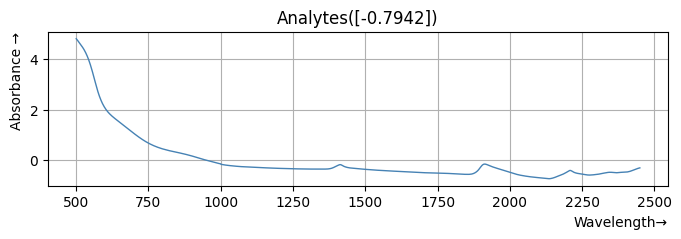

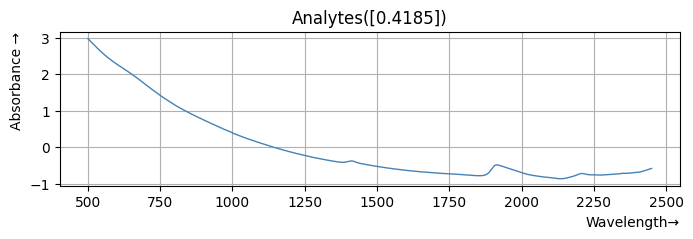

In [ ]:
dls = get_dls(paths_kssl, bs=512)
dls.show_batch(max_n=2)

In [ ]:
# Create Learner
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score())

SuggestedLRs(valley=0.0003981071640737355)

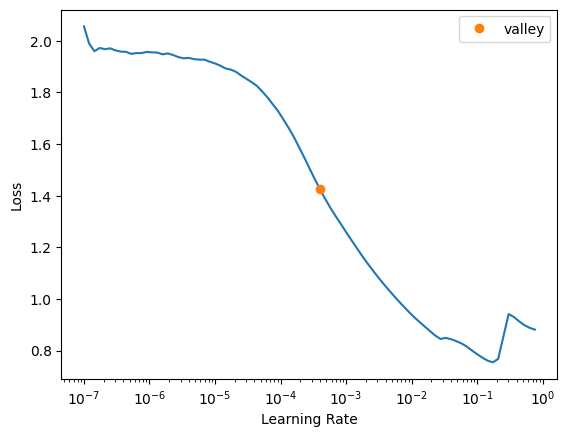

In [ ]:
learn.lr_find()

In [ ]:
# params
ds_name = 'kssl'
lr = 2e-3
epochs = 20

In [ ]:
# to do
# fit
# save model
# evaluate load model
# save metrics
learn.fit_one_cycle(20, 5e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.361248,0.278901,-0.146890,00:36
1,0.264830,0.284409,-0.169538,00:33
2,0.231860,0.269901,-0.109878,00:37
3,0.221813,0.225034,0.074623,00:34
4,0.214022,0.220733,0.092310,00:34
5,0.205264,0.196972,0.190019,00:30
6,0.197119,0.199346,0.180256,00:30
7,0.190594,0.190450,0.216836,00:31
8,0.182406,0.179663,0.261196,00:33
9,0.173086,0.246688,-0.014423,00:33


#### Eval on KSSL

In [ ]:
preds_kssl, targs_kssl = learn.get_preds(ds_idx=1)

In [ ]:
model_name = f'xresnet18-kex-nirs-{ds_name}-{epochs}-epochs-lr-{lr:.1e}-r2-{r2_score(targs_kssl, preds_kssl):.2}-{current_date()}'

In [ ]:
learn.save(model_name)

Path('models/xresnet18-kex-nirs-kssl-20-epochs-lr-2.0e-03-r2-0.69-2023-06-12.pth')

In [ ]:
dls_lucas = get_dls(paths_lucas)

In [ ]:
preds_lucas, targs_lucas = learn.get_preds(dl=dls_lucas.valid)

#### Eval on LUCAS

In [ ]:
# Eval on 
r2_score(targs_lucas, preds_lucas)

-0.2357146436679538

#### Finetune LUCAS on KSSL

In [ ]:
dls_lucas = get_dls(paths_lucas[:100])

In [ ]:
# Pre-trained model (KSSL)
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
layers = [m for m in flatten_model(model) if has_params(m)]

stats = ActivationStats(with_hist=True, modules=layers)
learn = Learner(dls_lucas, model, 
                loss_func=MSELossFlat(), 
                metrics=R2Score(), 
                cbs=[stats])

In [ ]:
weights_paths = root_dir/ 'models/xresnet18-kex-nirs-kssl-20-epochs-lr-2.0e-03-r2-0.69-2023-06-12.pth'
xresnet_dict = torch.load(weights_paths, map_location=torch.device(device)) 
model.load_state_dict(xresnet_dict['model'])

<All keys matched successfully>

In [ ]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,r2_score,time
0,0.107413,0.150355,-0.730222,00:06
1,0.103646,0.198246,-1.281336,00:06
2,0.108519,0.210532,-1.422717,00:06
3,0.109514,0.149991,-0.726039,00:06
4,0.111059,0.143132,-0.647101,00:06
5,0.109082,0.165962,-0.909827,00:06
6,0.110285,0.161305,-0.856236,00:07
7,0.108166,0.139634,-0.606850,00:07
8,0.106968,0.129508,-0.490324,00:07
9,0.106178,0.125865,-0.448399,00:07


In [ ]:
# https://forums.fast.ai/t/interpreting-activationstats-color-dim-graphs-and-fixing-bad-layers/64742

In [ ]:
#to_detach(stats, cpu=True)

In [ ]:
res = learn.activation_stats.stats.itemgot(0).itemgot('hist'); 
res = torch.stack(tuple(res)).t().float().log1p(); res
res.to('cpu')

tensor([[11.7870, 11.7646, 11.7655, 11.7739, 11.7476, 11.7830, 11.7638, 11.7762,
         11.7293, 11.8070, 11.7733, 11.7673, 11.7606, 11.7792, 11.7455, 11.7611,
         11.7554, 11.7718, 11.7446, 11.7647],
        [11.5530, 11.5409, 11.5542, 11.5394, 11.5584, 11.5360, 11.5350, 11.5586,
         11.5635, 11.5384, 11.5597, 11.5326, 11.5527, 11.5410, 11.5451, 11.5540,
         11.5533, 11.5423, 11.5477, 11.5503],
        [11.0874, 11.0830, 11.0725, 11.0924, 11.0829, 11.0844, 11.0783, 11.0913,
         11.0995, 11.0817, 11.0756, 11.0919, 11.0976, 11.0855, 11.1038, 11.0830,
         11.0979, 11.0867, 11.1048, 11.0876],
        [10.7076, 10.7258, 10.7429, 10.7145, 10.7468, 10.7015, 10.7383, 10.7216,
         10.7540, 10.6946, 10.7513, 10.7239, 10.7245, 10.7376, 10.7289, 10.7476,
         10.7485, 10.7204, 10.7416, 10.7337],
        [10.3789, 10.4237, 10.3702, 10.4208, 10.4076, 10.4184, 10.3861, 10.4080,
         10.4013, 10.4127, 10.3700, 10.4013, 10.4176, 10.3744, 10.4022, 10.4032,
      

In [ ]:
def plot_stats(activation_stats, idx, figsize=(10,5), ax=None):
    res = activation_stats.stats.itemgot(idx).itemgot('hist')
    res = torch.stack(tuple(res)).t().float().log1p().to('cpu')
    
    if ax is None: ax = subplots(figsize=figsize)[1][0]
    ax.imshow(res, origin='lower')
    ax.axis('off');

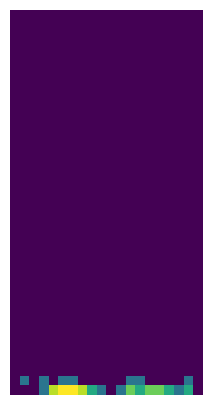

In [ ]:
plot_stats(learn.activation_stats, -1)

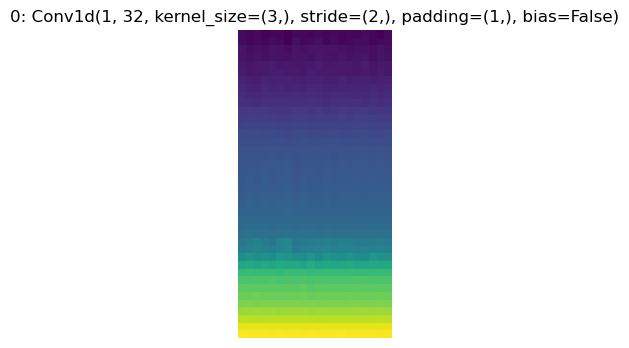

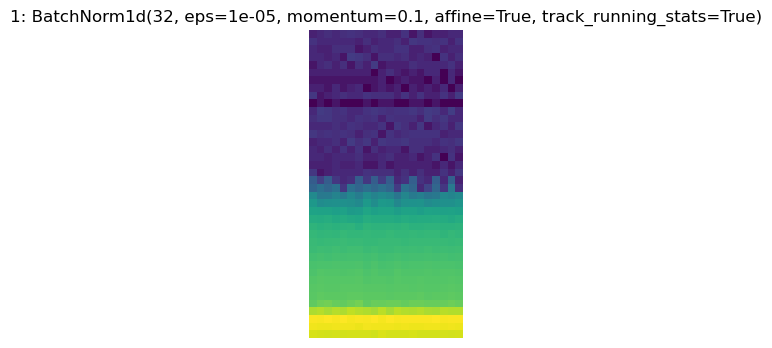

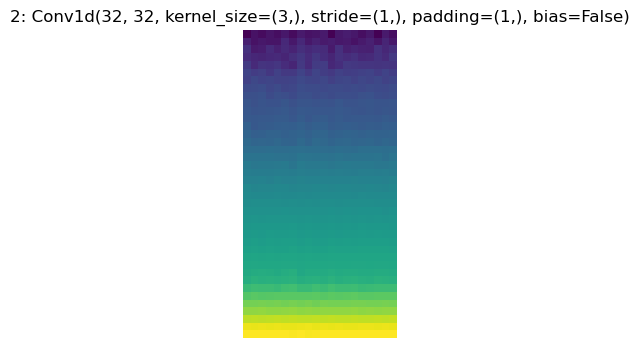

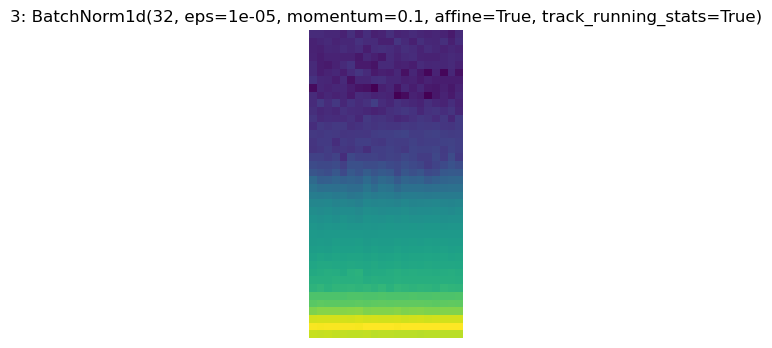

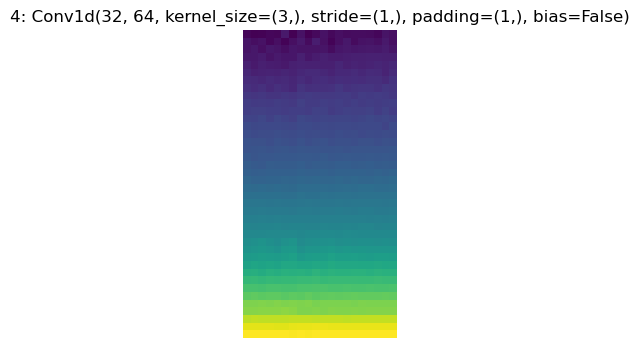

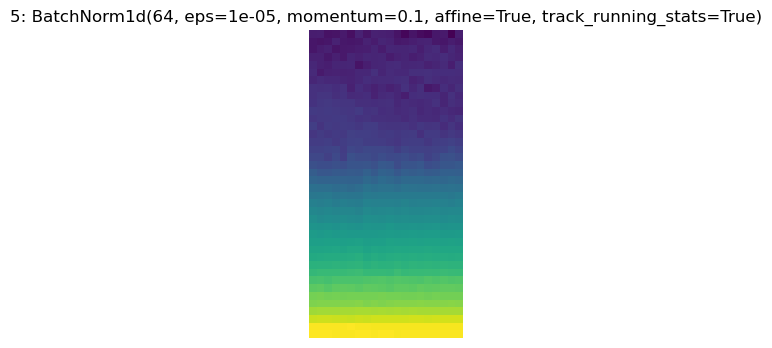

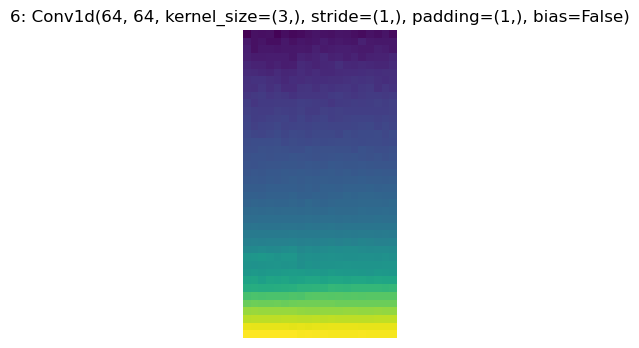

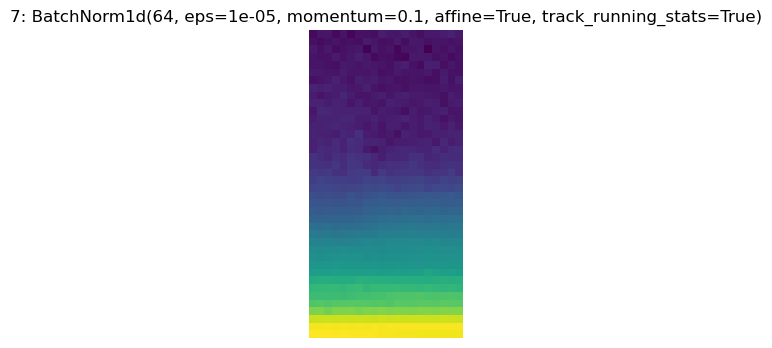

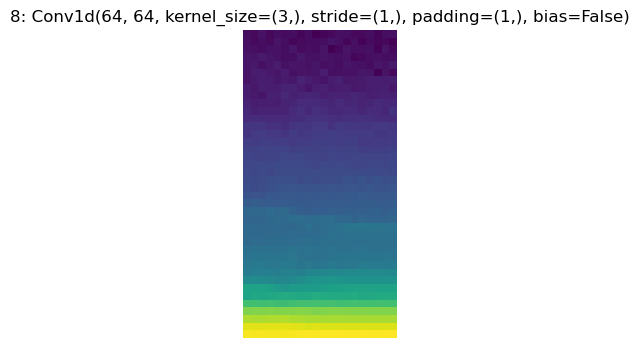

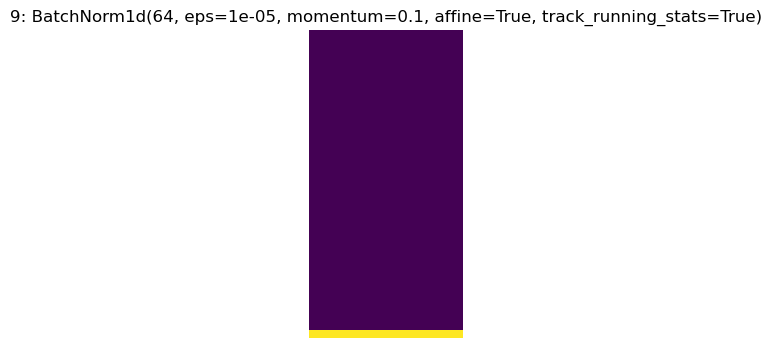

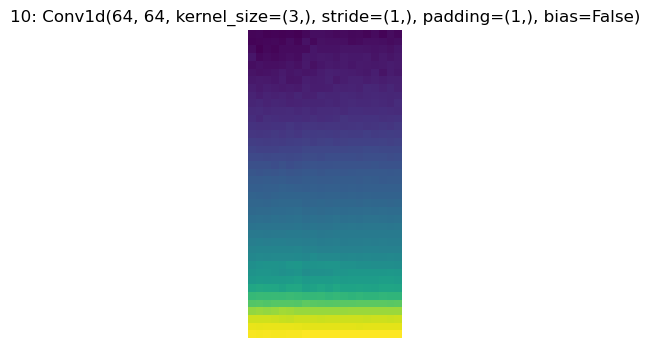

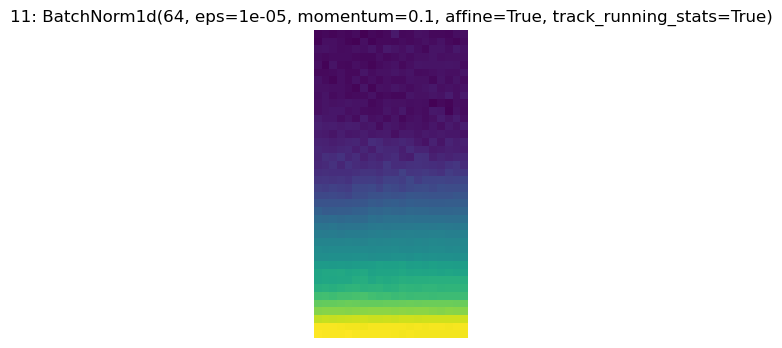

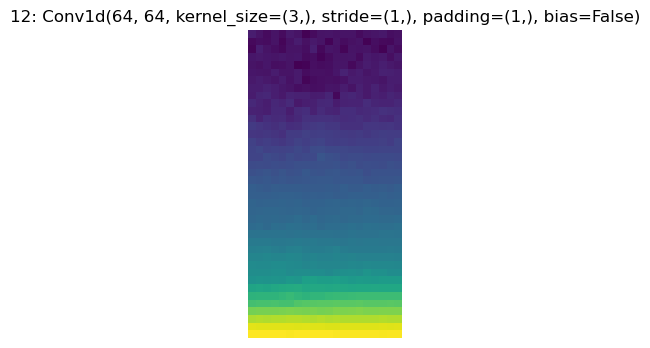

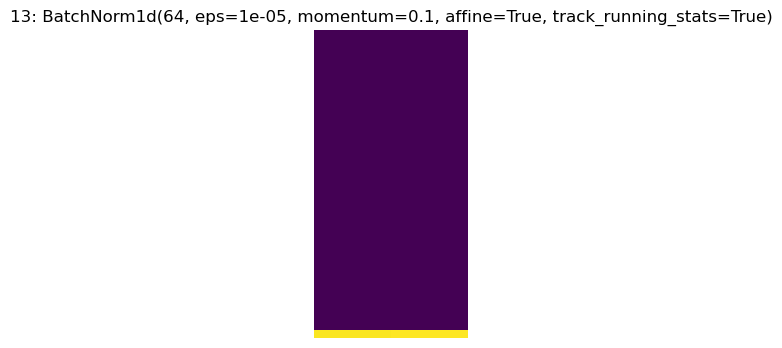

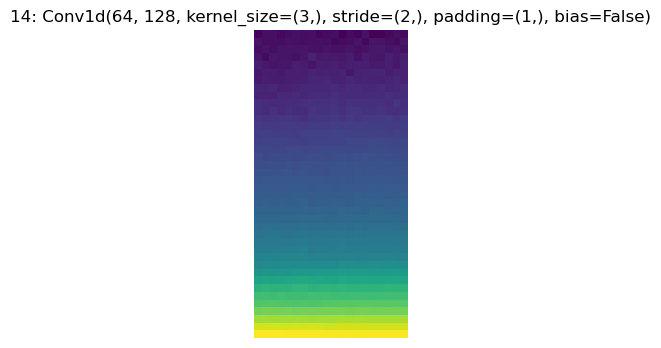

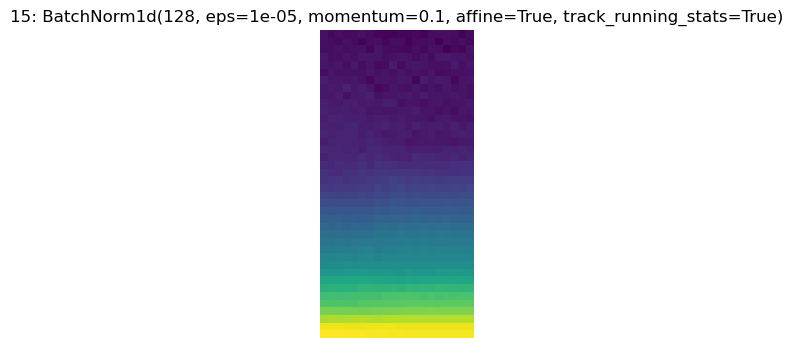

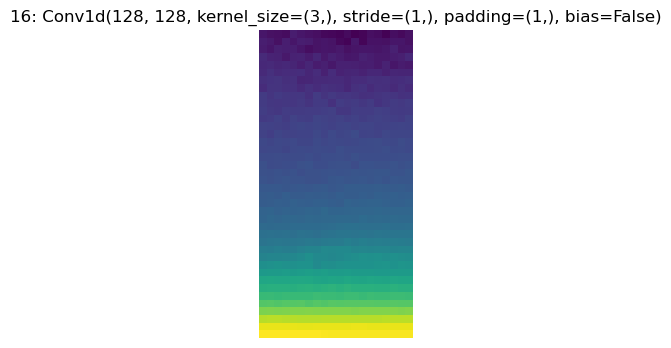

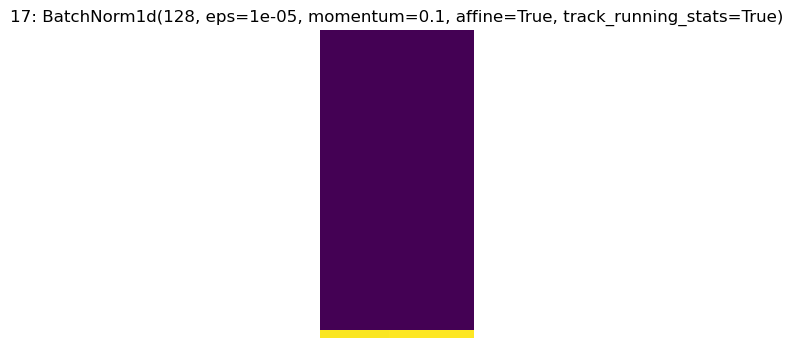

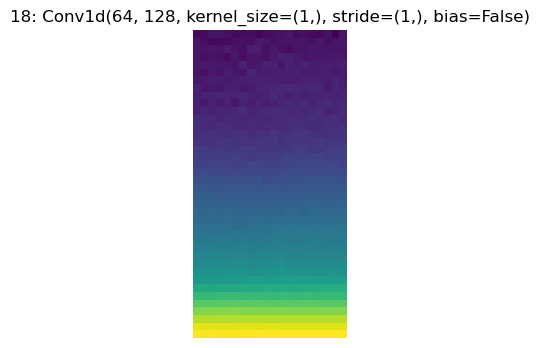

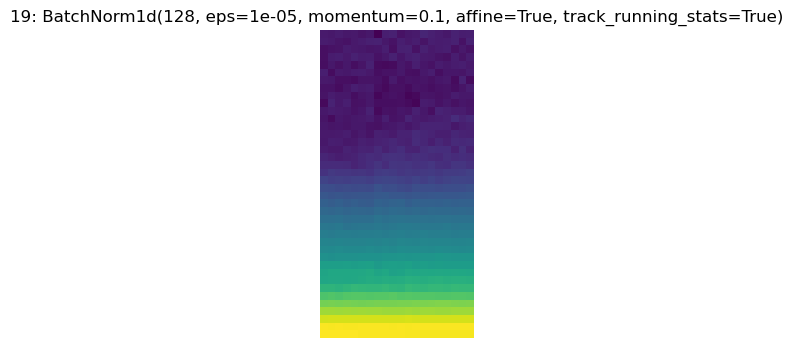

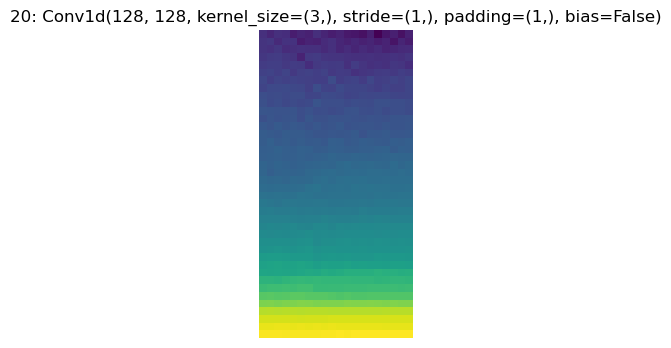

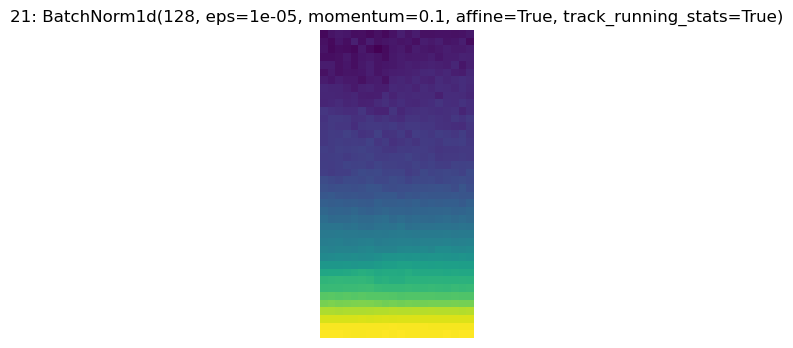

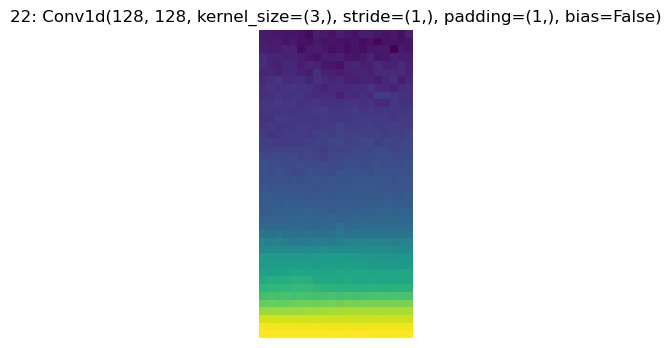

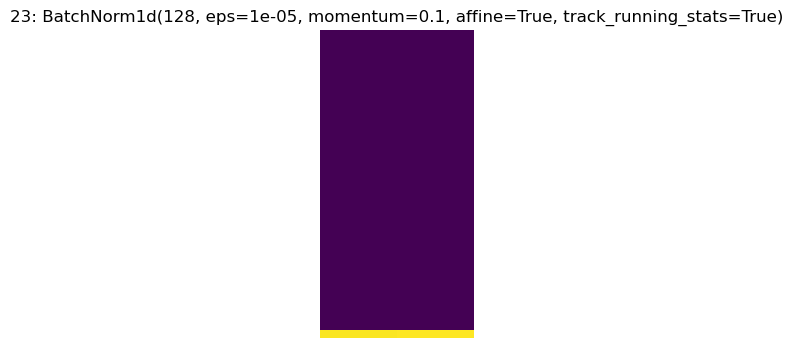

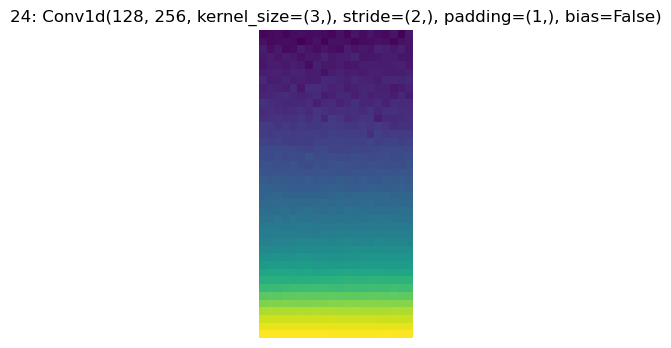

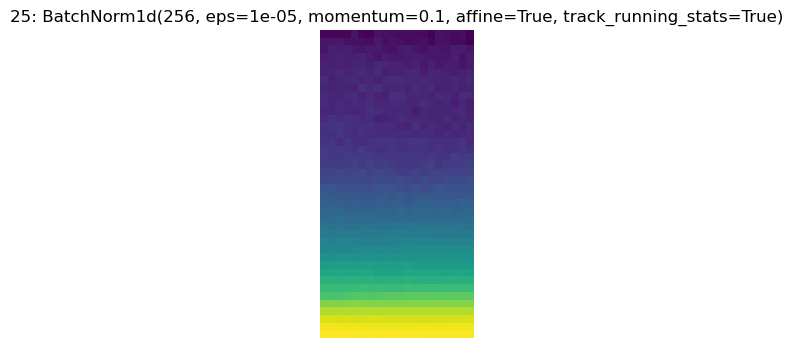

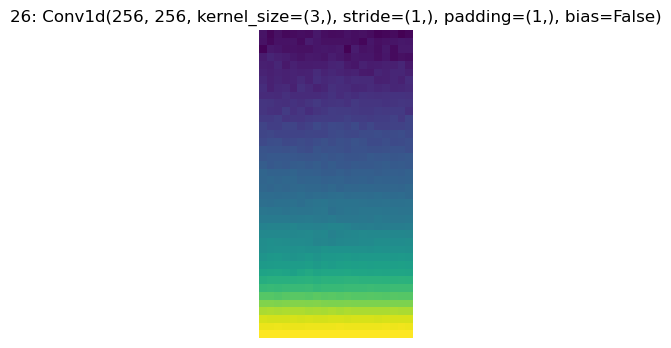

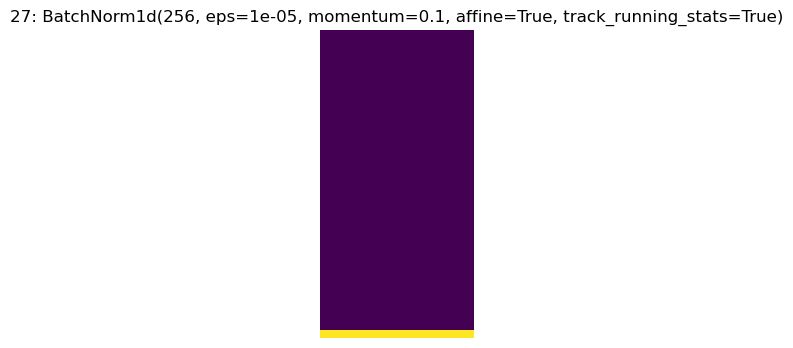

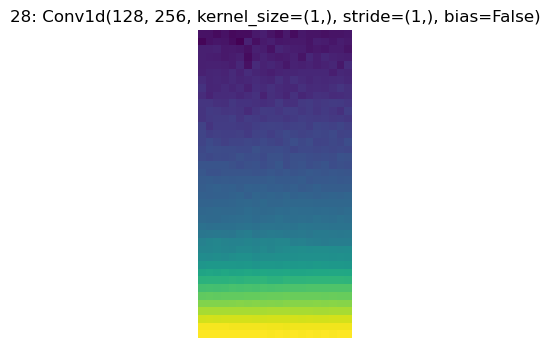

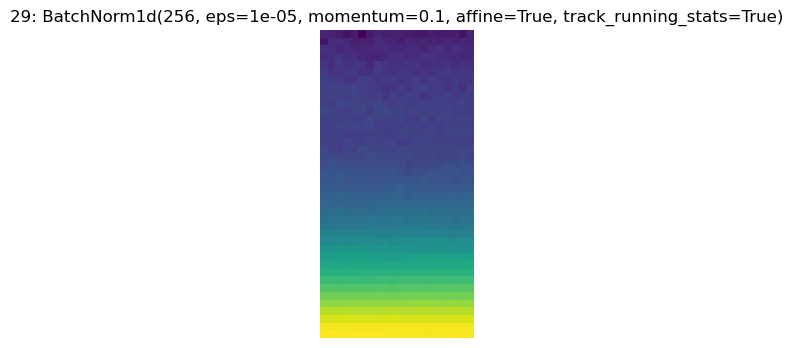

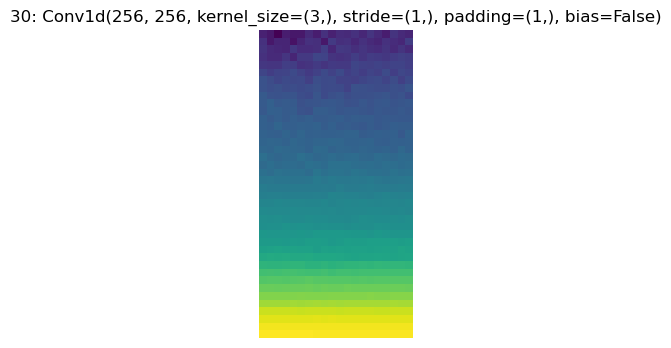

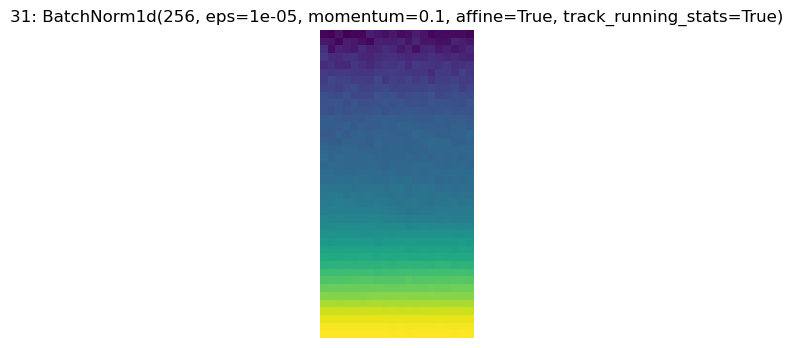

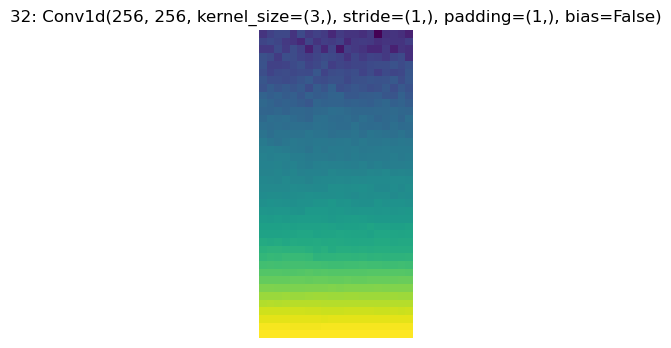

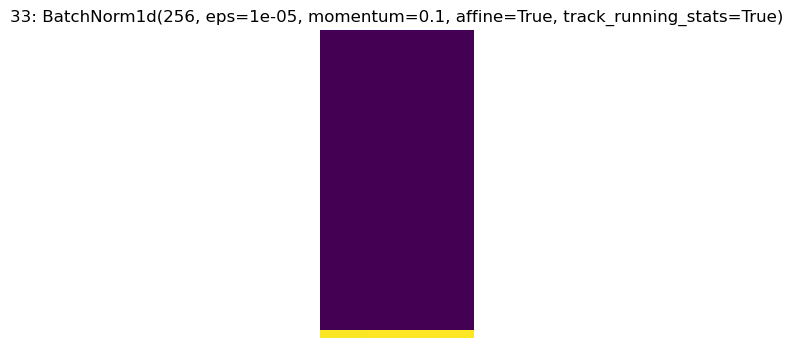

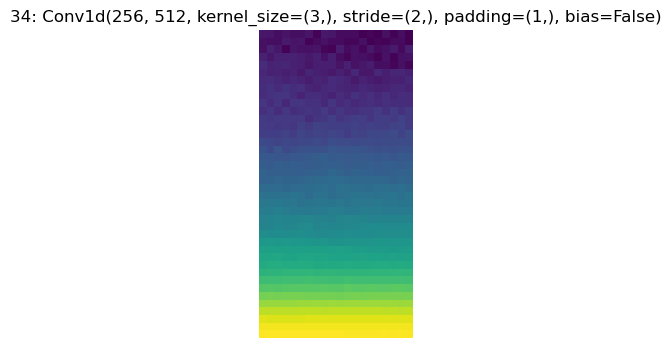

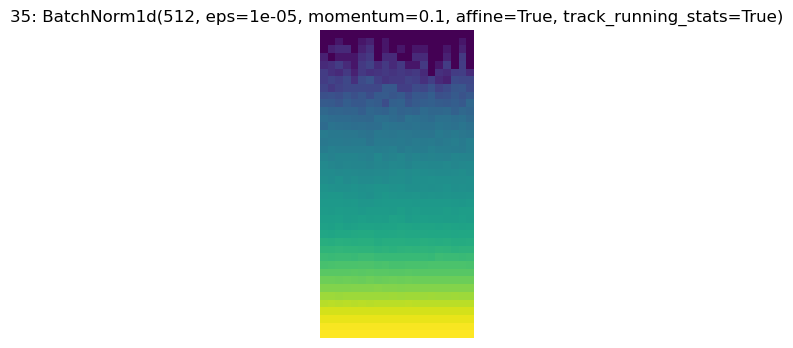

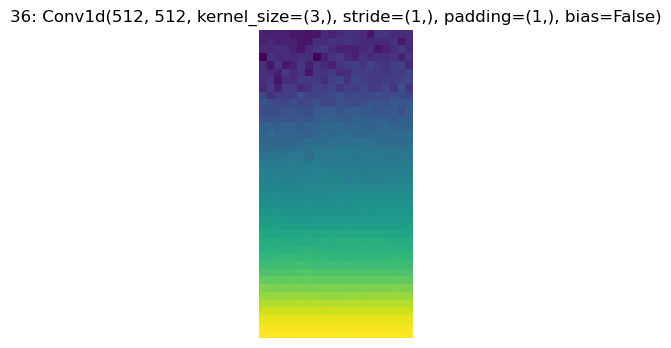

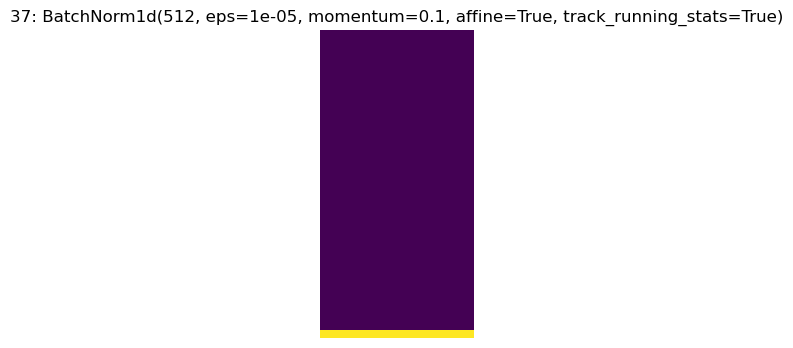

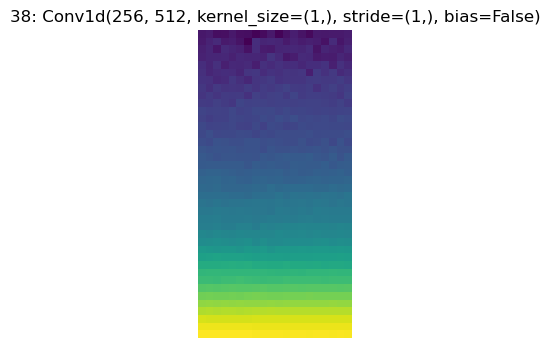

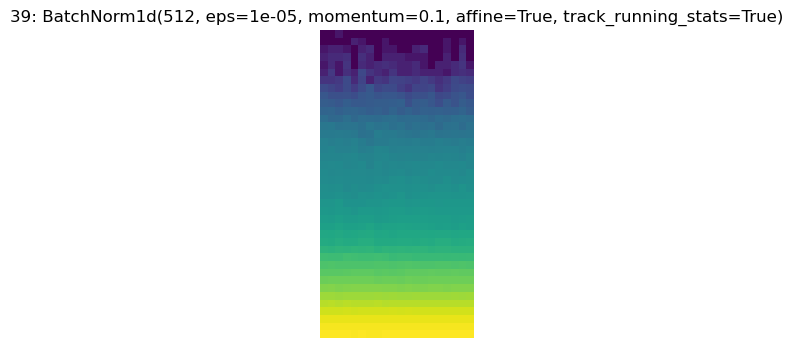

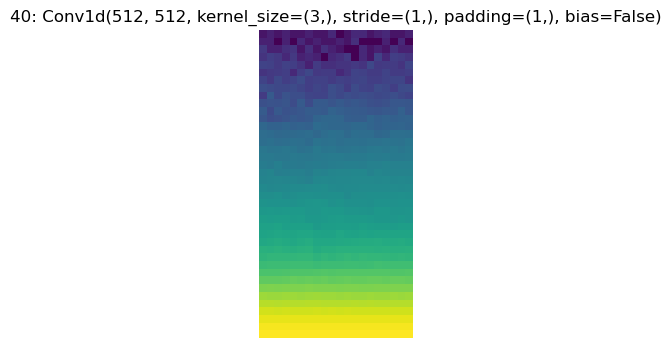

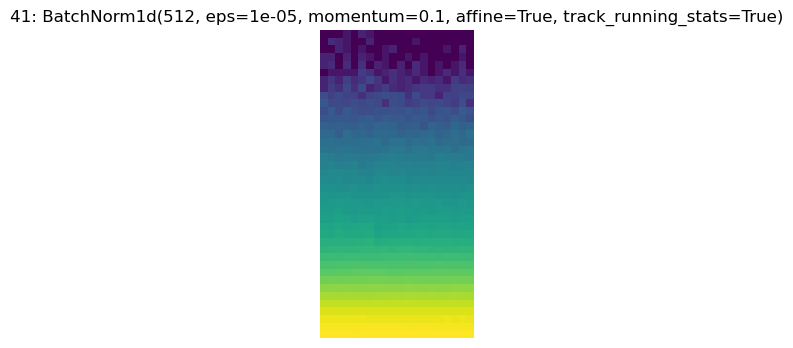

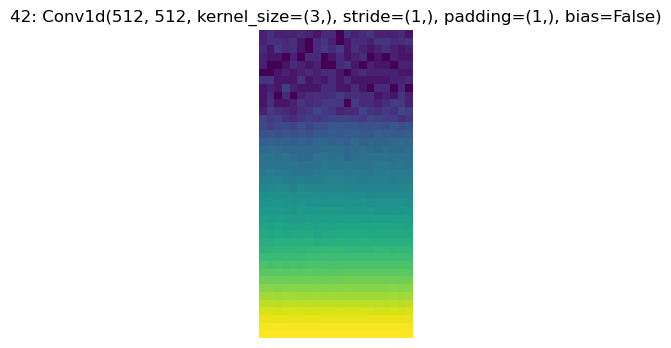

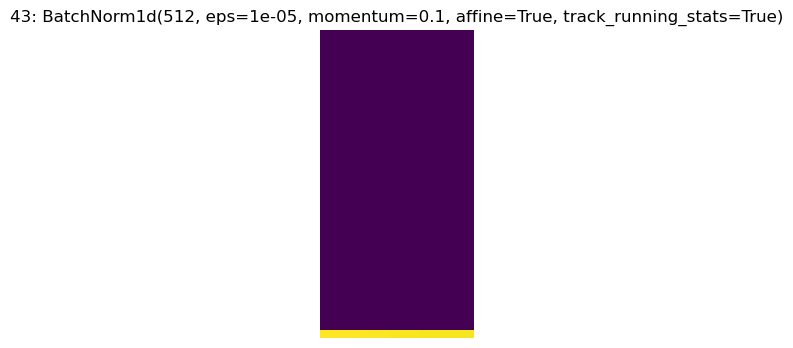

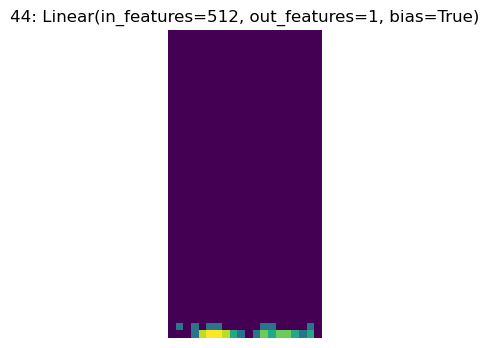

In [ ]:
#layers = [m for m in flatten_model(model) if has_params(m)]v
for i, layer in enumerate(layers):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_title(f'{i}: {layer}')
    plot_stats(learn.activation_stats, i, ax=ax)
    #stats.color_dim(i, ax=ax)

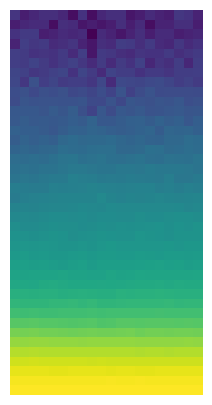

In [ ]:
#learn.activation_stats.color_dim(-5)

In [ ]:
for layer in flatten_model(learn):
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.BatchNorm1d):
        for param in layer.parameters():
            param.requires_grad = True
    else:
        for param in layer.parameters():
            param.requires_grad = False      

SuggestedLRs(valley=0.0010000000474974513)

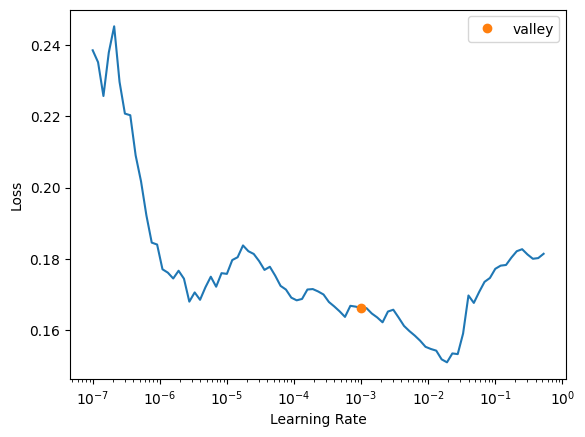

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 1e-3)
#learn.fit_one_cycle(20, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,r2_score,time
0,0.113442,0.110231,0.249803,00:29
1,0.095094,0.093880,0.361085,00:32
2,0.089150,0.082234,0.440345,00:32
3,0.086316,0.081131,0.447853,00:31
4,0.082815,0.078304,0.467093,00:32
5,0.083117,0.074273,0.494525,00:33
6,0.084979,0.073475,0.499951,00:32
7,0.084978,0.077548,0.472235,00:31
8,0.076220,0.072954,0.503497,00:34
9,0.075383,0.073276,0.501307,00:34


In [ ]:
preds_lucas, targs_lucas = learn.get_preds()

In [ ]:
# r2: 0.62 when finetuned over 20 epochs and lr=slice(1e-5,1e-3), bs=32
# r2: 0.54 when finetuned over 20 epochs and lr=1e-3, bs=32 and only batchnorm and linear trainable

r2_score(targs_lucas, preds_lucas)

0.626576297559692